In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from optparse import OptionParser
from PIL import Image#, ImageTk
from subprocess import Popen, PIPE
import matplotlib.patches as patches
import scipy.ndimage

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = np.load('data_64x64.npz')
images = data['images']
classs = data['labels'] 
data.close() 

## Labels

- Reject: `0`
- Face-on: `F`
- inclination>45 : `inclination`

In [3]:
N = images.shape[0]

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
GrayImages = np.zeros((N,64*64))

for i in range(N):
    GrayImages[i,:] = rgb2gray(images[i]).reshape(-1)
    
labels = classs[1]
pgcIDs = classs[0]
    
GrayImages.shape, labels.shape

((60468, 4096), (60468,))

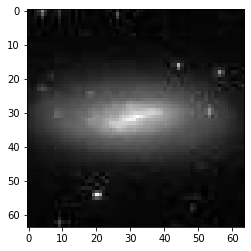

In [6]:
plt.imshow(GrayImages[4].reshape(64,64), cmap=plt.get_cmap('gray'))

In [7]:
def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [8]:
def train_test_split(images, labels, pgcIDs, seed=0):
    
    n = len(labels)

    indices = np.arange(n)
    indices = esn_shuffle(indices, seed=seed)


    images_ = images[indices]
    labels_ = labels[indices]
    pgcIDs_ = pgcIDs[indices]

    #################

    indices = np.arange(2000)
    images_test  = images_[indices]
    labels_test  = labels_[indices]
    pgcIDs_test  = pgcIDs_[indices]

    ################# 

    indices = np.arange(2000, n)
    images_train = images_[indices]
    labels_train = labels_[indices]
    pgcIDs_train = pgcIDs_[indices]


    ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
    images_train = images_train[ibx]
    labels_train = labels_train[ibx]
    pgcIDs_train = pgcIDs_train[ibx]

    #################
    # Taking only unique galxies in the test set
    # This is the brute-force approach.
    # I need to make this better in the future

    unique_IDs = []
    unique_inx = []

    for i, id in enumerate(pgcIDs_test):
        if not id in unique_IDs:
            unique_IDs.append(id)
            unique_inx.append(i)


    images_test  = images_test[unique_inx]
    labels_test  = labels_test[unique_inx]
    pgcIDs_test  = pgcIDs_test[unique_inx]
    
    trainDict = {'X':images_train, 'y':labels_train, 'id':pgcIDs_train}
    testDict  = {'X':images_test, 'y':labels_test, 'id':pgcIDs_test}
    
    return trainDict, testDict 

In [9]:
indx = (labels>1)

GrayImages = GrayImages[indx]
pgcIDs = pgcIDs[indx]
labels = labels[indx]

In [10]:
labels.shape, pgcIDs.shape, GrayImages.shape

((44220,), (44220,), (44220, 4096))

In [11]:
Train_seed0, Test_seed0 = train_test_split(GrayImages, labels, pgcIDs, seed=0)

Train_seed64, Test_seed64 = train_test_split(GrayImages, labels, pgcIDs, seed=64)

In [17]:
from joblib import dump, load


def metrics(y1, y2):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    RMSE = np.sqrt(np.mean((y1-y2)**2))
    MAE = np.mean(np.abs(y1-y2))

    print('MAE: %.3f'%MAE, ' RMSE: %.3f'%RMSE)
########################################

def evalModel(Test_data, modelFile='', color='#1f77b4', ax=None, title='', model=None):
    
    if model is None:
        try:
            model = load(modelFile) 
        except:
            print("Please provide either a model or a file that contains the model.")
            return None
        
    
    inc_p = model.predict(Test_data['X'])  # predictions
    inc_m = Test_data['y']                 # measurements

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)) 
        
    ax.plot(inc_m, inc_p+45, '.', color=color)
    ax.plot([48,95],[48,95], 'k:')
    ax.set_xlim(48,95)
    ax.set_ylim(48,95)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)
    
    return inc_p+45, inc_m


 Seed: 0 #############
MAE: 3.436  RMSE: 5.458

 Seed: 64 #############
MAE: 3.313  RMSE: 5.090
CPU times: user 2.03 s, sys: 1.34 s, total: 3.38 s
Wall time: 2.25 s


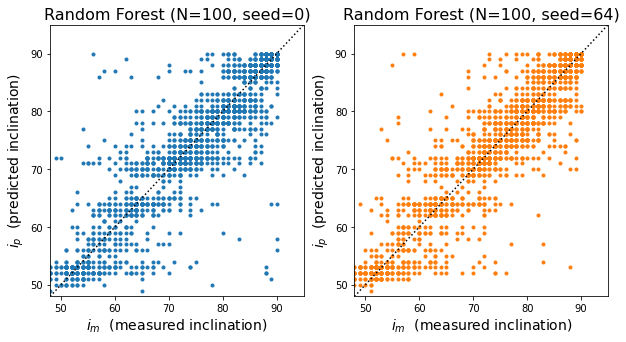

In [13]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'RF100.joblib', 
                         title='Random Forest (N=100, seed=0)', ax=ax[0]) # N is the number of estimators
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'RF100_seed64.joblib', 
                         title='Random Forest (N=100, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)


 Seed: 0 #############
MAE: 4.259  RMSE: 6.476

 Seed: 64 #############
MAE: 4.167  RMSE: 6.216
CPU times: user 12min 45s, sys: 2.11 s, total: 12min 48s
Wall time: 13min 2s


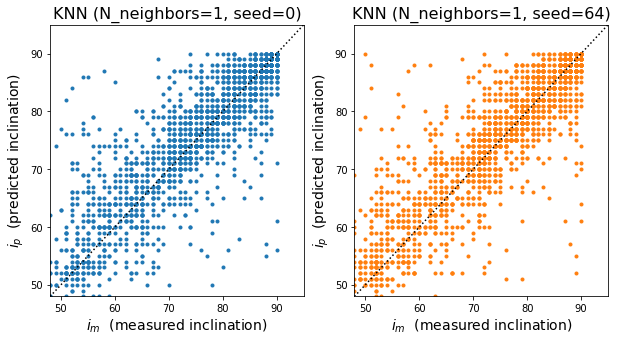

In [14]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN1.joblib', 
                         title='KNN (N_neighbors=1, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN1_seed64.joblib', 
                         title='KNN (N_neighbors=1, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)


 Seed: 0 #############
MAE: 4.348  RMSE: 6.661

 Seed: 64 #############
MAE: 4.197  RMSE: 6.262
CPU times: user 13min, sys: 1.95 s, total: 13min 2s
Wall time: 13min 16s


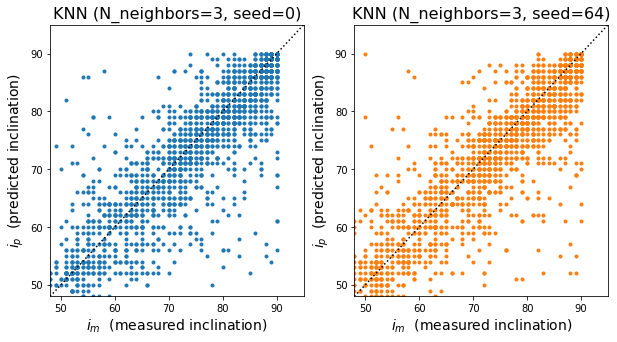

In [15]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN3.joblib', 
                         title='KNN (N_neighbors=3, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN3_seed64.joblib', 
                         title='KNN (N_neighbors=3, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)


 Seed: 0 #############
MAE: 4.427  RMSE: 7.016

 Seed: 64 #############
MAE: 4.263  RMSE: 6.413
CPU times: user 13min, sys: 3.52 s, total: 13min 3s
Wall time: 13min 31s


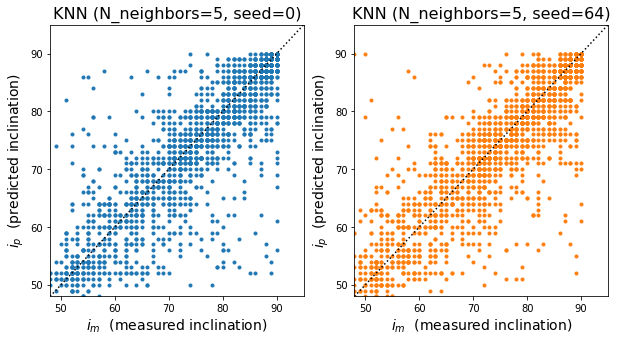

In [16]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN5.joblib', 
                         title='KNN (N_neighbors=5, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN5_seed64.joblib', 
                         title='KNN (N_neighbors=5, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)


 Seed: 0 #############
MAE: 4.072  RMSE: 6.434

 Seed: 64 #############
MAE: 3.851  RMSE: 5.782
CPU times: user 13min 6s, sys: 3.03 s, total: 13min 9s
Wall time: 13min 37s


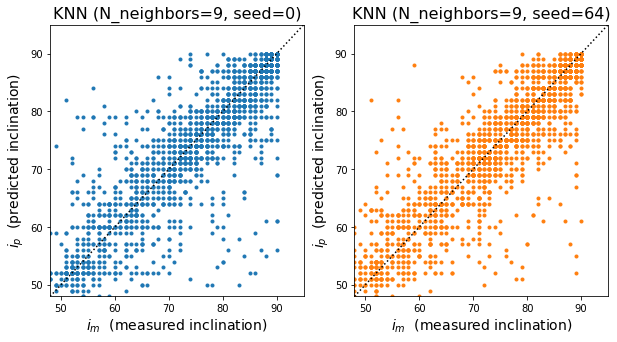

In [17]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN9.joblib', 
                         title='KNN (N_neighbors=9, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN9_seed64.joblib', 
                         title='KNN (N_neighbors=9, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)


 Seed: 0 #############
MAE: 4.364  RMSE: 6.943

 Seed: 64 #############
MAE: 4.042  RMSE: 6.036
CPU times: user 13min 6s, sys: 3.84 s, total: 13min 10s
Wall time: 13min 38s


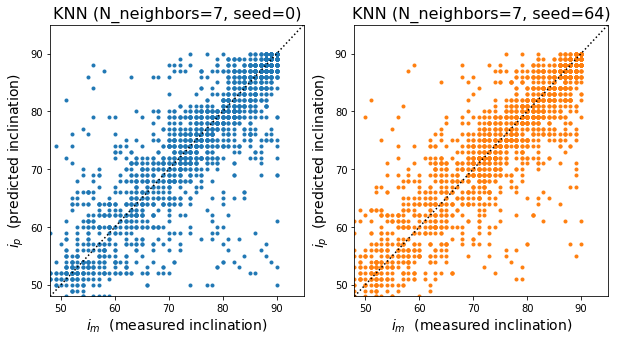

In [18]:
%%time 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

print('\n Seed: 0 #############')
inc_p, inc_m = evalModel(Test_seed0, 'KNN7.joblib', 
                         title='KNN (N_neighbors=7, seed=0)', ax=ax[0])
metrics(inc_p, inc_m)

inc_p, inc_m = evalModel(Test_seed64, 'KNN7_seed64.joblib', 
                         title='KNN (N_neighbors=7, seed=64)', ax=ax[1], color='#ff7f0e')

print('\n Seed: 64 #############')
metrics(inc_p, inc_m)

In [13]:
Test_seed64['X'].shape

(1865, 4096)

In [14]:
%%time 
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1, random_state=0, eval_metric='mlogloss')
model.fit(Train_seed0['X'], Train_seed0['y']-45)
dump(model, 'test_XGB3.joblib')

CPU times: user 6h 53min 5s, sys: 3.69 s, total: 6h 53min 9s
Wall time: 6h 53min 1s


['test_XGB3.joblib']

MAE: 3.540  RMSE: 5.440


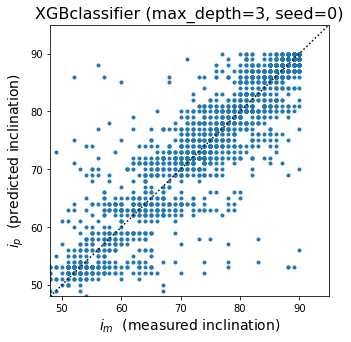

In [23]:
inc_p, inc_m = evalModel(Test_seed0, 'test_XGB3.joblib', 
                         title='XGBclassifier (max_depth=3, seed=0)')
metrics(inc_p, inc_m)

In [16]:
%%time 

model5 = XGBClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=0, eval_metric='mlogloss')
model5.fit(Train_seed0['X'], Train_seed0['y']-45)
dump(model5, 'test_XGB5.joblib')

CPU times: user 11h 43min, sys: 3.69 s, total: 11h 43min 4s
Wall time: 11h 43min 27s


['test_XGB5.joblib']

MAE: 3.537  RMSE: 5.338


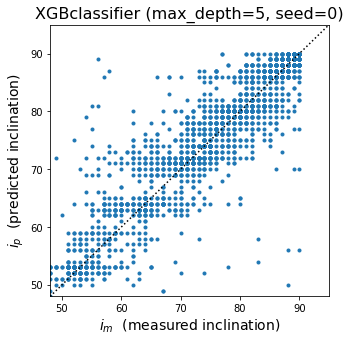

In [24]:
inc_p, inc_m = evalModel(Test_seed0, 'test_XGB5.joblib', 
                         title='XGBclassifier (max_depth=5, seed=0)')
metrics(inc_p, inc_m)

In [31]:
# TensorFlow and tf.keras
import tensorflow as tf


model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.20),    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(46),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
n_epochs = 12
model.fit(Train_seed0['X']/255., Train_seed0['y']-45, epochs=n_epochs, batch_size=512, shuffle=True,
         validation_data=(Test_seed0['X']/255., Test_seed0['y']-45)
         )

Epoch 1/12
72/72 [==============================] - 9s 117ms/step - loss: 7.2173 - accuracy: 0.0489 - val_loss: 9.1222 - val_accuracy: 0.0204
Epoch 2/12
72/72 [==============================] - 8s 116ms/step - loss: 5.5651 - accuracy: 0.0569 - val_loss: 5.3013 - val_accuracy: 0.0579
Epoch 3/12
72/72 [==============================] - 8s 115ms/step - loss: 4.8017 - accuracy: 0.0530 - val_loss: 5.4575 - val_accuracy: 0.0568
Epoch 4/12
72/72 [==============================] - 8s 115ms/step - loss: 3.9926 - accuracy: 0.0500 - val_loss: 4.2556 - val_accuracy: 0.0450
Epoch 5/12
72/72 [==============================] - 8s 115ms/step - loss: 3.6703 - accuracy: 0.0502 - val_loss: 5.2900 - val_accuracy: 0.0611
Epoch 6/12
72/72 [==============================] - 8s 117ms/step - loss: 3.3525 - accuracy: 0.0663 - val_loss: 4.8355 - val_accuracy: 0.0579
Epoch 7/12
72/72 [==============================] - 9s 119ms/step - loss: 3.3424 - accuracy: 0.0694 - val_loss: 3.5107 - val_accuracy: 0.0697
Epoch 

In [33]:
def plot_model_history(history, n_epochs=10):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

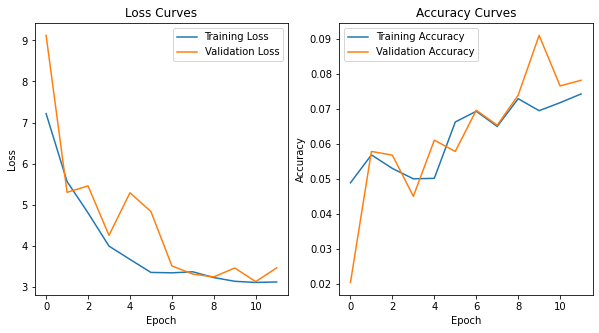

In [34]:
plot_model_history(model.history, n_epochs=n_epochs)

In [35]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(Test_seed0['X']/255.)

MAE: 5.349  RMSE: 7.512


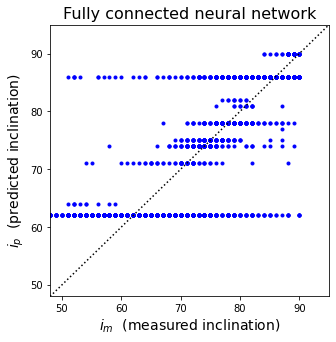

In [36]:
inc_p = np.argmax(predictions, axis=1)+45   # predictions
inc_m = Test_seed0['y']                     # measurements

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
ax.plot(inc_m, inc_p, '.', color='b')
ax.plot([48,95],[48,95], 'k:')
ax.set_xlim(48,95)
ax.set_ylim(48,95)
ax.set_title('Fully connected neural network', fontsize=16)
ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

metrics(inc_p, inc_m)